<a href="https://www.kaggle.com/code/mikedelong/let-s-explore-sunken-ships-with-python?scriptVersionId=139542996" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/shipwrecks-sunk-ships/Shipwrecks or Sunk ships.csv', parse_dates=['Sunk date'], )
df.head()

,Ship,Flag,Sunk date,Notes,Coordinates
0,Black Assarca shipwreck,Unknown,Early 7th century (Presumed),A wreck discovered at Black Assarca Island in ...,NaN
1,Globe Star,Singapore,27-Apr-73,A cargo ship that ran aground off Mombasa.[1],4°04′54″S 39°43′12″E
2,Gulland,Aden,13-Apr-51,A 545-ton Isles-class trawler built for World ...,04°02′50″S 39°43′57″E
3,Mtongwe,Tanzania,27-Apr-94,A Likoni and Mombasa route ferry that capsized...,NaN
4,Katina P,Greece,26-Apr-92,"An oil tanker that was damaged in a storm, spi...",25°35′S 32°59′E


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ship         3952 non-null   object
 1   Flag         3202 non-null   object
 2   Sunk date    3573 non-null   object
 3   Notes        3914 non-null   object
 4   Coordinates  1019 non-null   object
dtypes: object(5)
memory usage: 155.2+ KB


<Axes: ylabel='Frequency'>

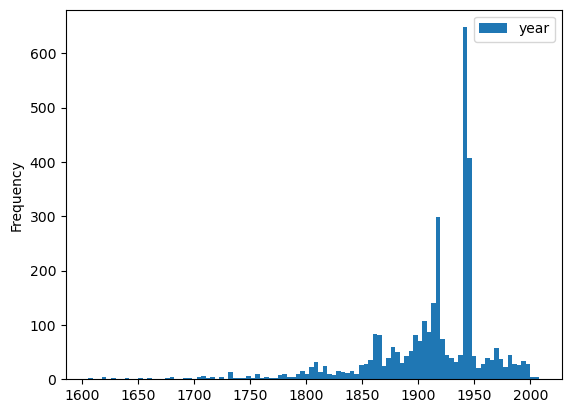

In [3]:
from numpy import nan
def get_year(arg) -> float:
    if isinstance(arg, float):
        return arg
    if isinstance(arg, str):
        if arg.isnumeric():
            return int(arg)
    pieces = arg.split('-')
    if pieces[-1].isnumeric():
        return 1900 + int(pieces[-1])
    pieces = arg.split()
    if pieces[-1].isnumeric():
        return int(pieces[-1])
    return nan
df['year'] = df['Sunk date'].apply(get_year)
# we can cut off the left tail of the histogram and not lose any story
df[df['year'] > 1600][['year']].plot.hist(bins=100)

Are we shocked that they cluster around World War II? We are not.

What percentage of cases have something possibly useful in the Sunk date column but we don't yet know the year?

In [4]:
100 * round(len(df[(df['year'].isna()) & (df['Sunk date'] != 'Unknown')])/len(df), 2)

12.0

Let's see if we can salvage anything from the Coordinates. They are a little noisy in a couple of ways.

In [5]:
# remove special cases and extra coordinates
def drop_extras(arg):
    if isinstance(arg, float):
        return nan
    if arg in {'E', 'An E'}:
        return nan
    if not isinstance(arg, str):
        return nan
    arg = arg.split('/')[0]
    return arg

df['Coordinates'] = df['Coordinates'].apply(func=drop_extras)

df[df['Coordinates'].notnull()][['Coordinates']].sample(n=5)
# this data is kind of messy; we'll need to do further work before we can make a map

,Coordinates
3710,34°33′N 11°45′E
678,55°03′47″N 49°09′07″E
3291,27°00′14.31″S 153°26′27.92″E
546,38°08′N 13°22′E
3922,26°14′31″S 111°12′48″E


In [6]:
# we need to map non-ASCII primes and double-primes into ASCII single and double quotes
# and for some reason our data contains a non-ASCII W
char_map = {8242: 39, 8243: 34, 65279: 87}
def fix_domain(arg):
    if isinstance(arg, float): 
        return arg
    arg = [ord(char) for char in list(arg)]
    arg = [char if char not in char_map.keys() else char_map[char] for char in arg]
    result = ''.join([chr(char) for char in arg])
    return result.replace('WW', 'W')

df['Coordinates'] = df['Coordinates'].apply(func=fix_domain)
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year
3712,HMS Athenienne,Royal Navy,20 October 1806,Ran aground in the Strait of Sicily.[62],37°47'N 10°46'E,1806.0
268,Akigumo,Imperial Japanese Navy,11-Apr-44,A Kagerō-class destroyer that was torpedoed by...,06°43'N 122°23'E,1944.0
229,Lisbon Maru,Imperial Japanese Navy,2-Oct-42,A troopship and prisoner-of-war transport that...,"30°13'48""N 122°45'54""E",1942.0
3345,Postboy,Australia,1905,A schooner that was wrecked at Arno Bay.,"33°55'12""S 136°34'12""E",1905.0
42,Empire Barracuda,United Kingdom,15-Dec-42,A cargo ship that was torpedoed by the U-77 of...,35°30'N 06°17'W,1942.0


In [7]:
# now we can split our coordinates into latitude and longitude
def get_coord(arg, index):
    if not isinstance(arg, str):
        return arg
    pieces = arg.split()
    return pieces[index].strip()

df['latitude_str'] = df['Coordinates'].apply(func=get_coord, args=(0, ))
df['longitude_str'] = df['Coordinates'].apply(func=get_coord, args=(1, ))
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year,latitude_str,longitude_str
1093,SS James Eagan Layne,United States,21-Mar-45,"A Liberty ship, situated in 22 metres (72 ft) ...",50°19.602'N 4°14.714'W,1945.0,50°19.602'N,4°14.714'W
3455,HMAS Wallaroo,Royal Australian Navy,11-Jun-43,A Bathurst-class corvette that collided with H...,"31°54'24""S 114°37'31""E",1943.0,"31°54'24""S","114°37'31""E"
774,HMS Havant,Royal Navy,1-Jun-40,A H-class destroyer that was scuttled after ta...,"51°08'00""N 2°15'49""E",1940.0,"51°08'00""N","2°15'49""E"
3842,U-317,Kriegsmarine,26-Jun-44,A Type VIIC/41 U-boat that was sunk by British...,62°3'N 1°45'E,1944.0,62°3'N,1°45'E
808,USS Miantonomah,United States Navy,25-Sep-44,A cargo ship and minelayer sunk by a mine off ...,"49°26'29""N 0°11'31""E",1944.0,"49°26'29""N","0°11'31""E"


In [8]:
# it would be nice to use a regex here but our data is a little irregular still,
# we have varying precision in our data, and we can either fill in missing zeros
# or we can just parse our data as is
from numpy import nan
def get_dd(arg) -> float:
    if not isinstance(arg, str):
        return arg
    multiplier = -1 if arg[-1] in {'S', 'W'} else 1
    pieces = arg[:-1].replace('°', ' ').replace('\'', ' ').replace('\"', ' ').split()
    return multiplier * sum([float(piece)/pow(60, index) for index, piece in enumerate(pieces)])

df['latitude'] = df['latitude_str'].apply(func=get_dd)
df['longitude'] = df['longitude_str'].apply(func=get_dd)
df = df.drop(columns=['latitude_str', 'longitude_str'])
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year,latitude,longitude
3021,USS Pilotfish,United States Navy,25-Jul-46,A Balao-class submarine that sunk at Bikini At...,30°26'N 140°53'E,1946.0,30.433333,140.883333
631,MS Rigel,Nazi Germany,27-Nov-44,A prisoner-of-war transport that was sunk by S...,"65°49'16""N 12°20'10""E",1944.0,65.821111,12.336111
155,Amagiri,Imperial Japanese Navy,23-Apr-44,A Fubuki-class destroyer that struck a mine ne...,02°10'S 116°45'E,1944.0,-2.166667,116.750000
176,Junyō Maru,Imperial Japanese Navy,18-Sep-44,"A ""hell ship"" that was sunk by HMS Tradewind, ...",2°53'S 101°11'E,1944.0,-2.883333,101.183333
119,Dara,United Kingdom,10-Apr-61,An ocean liner that suffered an internal explo...,"25°34'29""N 55°27'58""E",1961.0,25.574722,55.466111


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='longitude', ylabel='latitude'>

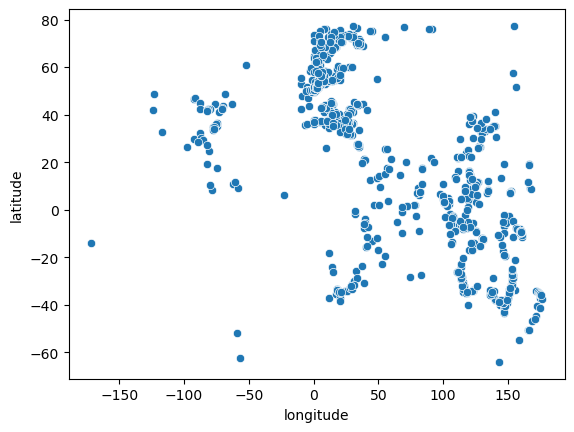

In [9]:
# now we can make a scatter plot
from seaborn import scatterplot
scatterplot(data=df[df['Coordinates'].notnull()], x='longitude', y='latitude')

This is kind of encouraging, as we can kind if see the outlines of some familiar features in the scatter plot. But this data would look better on a map.

In [10]:
# we need some text to put in our hover data
df['text'] = df.apply(axis=1, func=lambda x: '{} : {} : {}'.format(x['Ship'], x['Flag'], x['Sunk date']))
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year,latitude,longitude,text
714,Kronan,Swedish Navy,1 June 1676,The largest warship in the Swedish navy during...,"56°26'58""N 16°40'20""E",1676.0,56.449444,16.672222,Kronan : Swedish Navy : 1 June 1676
3330,Frances,South Australia,29 August 1840,A cutter that was wrecked in the Neptune Islands.,"35°33'00""S 136°12'00""E",1840.0,-35.550000,136.200000,Frances : South Australia : 29 August 1840
453,HMS Hereward,Royal Navy,29-May-41,An H-class destroyer that was sunk by German d...,35°20'N 26°20'E,1941.0,35.333333,26.333333,HMS Hereward : Royal Navy : 29-May-41
951,Georgia,Netherlands,20-Nov-27,An oil tanker that ran aground on Haisborough ...,"52°52'54""N 001°46'16""E",1927.0,52.881667,1.771111,Georgia : Netherlands : 20-Nov-27
274,USS Barbel,United States Navy,4-Feb-45,A Balao-class submarine that was sunk by Japan...,7°49'N 116°47'E,1945.0,7.816667,116.783333,USS Barbel : United States Navy : 4-Feb-45


In [11]:
import plotly.express as px
wrecks = px.scatter_geo(data_frame=df[df['Coordinates'].notnull()], lat='latitude', lon='longitude', hover_data='text', color='year')
wrecks.show()